# Complete XGBoost Tutorial: From Basics to Advanced

This hands-on tutorial will guide you through XGBoost with practical exercises.

## Table of Contents
1. Setup and Data Generation
2. Exploratory Data Analysis
3. Basic XGBoost Model
4. Understanding Parameters
5. Hyperparameter Tuning
6. Feature Importance and Interpretation
7. Advanced Techniques
8. Model Persistence and Deployment

---

## Part 1: Setup and Installation

First, let's install and import the necessary libraries.

In [ ]:
# Install required packages (uncomment if needed)
# !pip install xgboost scikit-learn pandas numpy matplotlib seaborn shap

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Display settings
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print(f"XGBoost Version: {xgb.__version__}")
print("Setup complete! ✓")

## Part 2: Generate Realistic Dataset

We'll create a realistic customer churn prediction dataset with:
- Multiple feature types (numerical, categorical)
- Missing values
- Non-linear relationships
- Class imbalance

In [ ]:
def generate_customer_churn_data(n_samples=5000):
    """
    Generate synthetic customer churn dataset
    """
    np.random.seed(RANDOM_STATE)
    
    # Customer demographics
    age = np.random.normal(45, 15, n_samples).clip(18, 80)
    tenure_months = np.random.exponential(24, n_samples).clip(1, 72)
    monthly_charges = np.random.normal(70, 30, n_samples).clip(20, 150)
    total_charges = monthly_charges * tenure_months + np.random.normal(0, 100, n_samples)
    
    # Service usage patterns
    num_products = np.random.poisson(2.5, n_samples).clip(1, 6)
    support_calls = np.random.poisson(1.5, n_samples)
    contract_type = np.random.choice(['Month-to-month', 'One year', 'Two year'], 
                                     n_samples, p=[0.5, 0.3, 0.2])
    payment_method = np.random.choice(['Electronic check', 'Credit card', 'Bank transfer', 'Mailed check'],
                                      n_samples, p=[0.35, 0.25, 0.25, 0.15])
    
    # Binary features
    has_tech_support = np.random.binomial(1, 0.4, n_samples)
    paperless_billing = np.random.binomial(1, 0.6, n_samples)
    auto_payment = np.random.binomial(1, 0.45, n_samples)
    
    # Create churn based on multiple factors (complex relationships)
    churn_probability = (
        0.15 +  # Base churn rate
        (contract_type == 'Month-to-month').astype(int) * 0.25 +
        (payment_method == 'Electronic check').astype(int) * 0.15 +
        (1 - has_tech_support) * 0.10 +
        (support_calls > 3).astype(int) * 0.20 +
        (tenure_months < 12).astype(int) * 0.25 +
        (monthly_charges > 100).astype(int) * 0.10 +
        (age < 30).astype(int) * 0.08 -
        (num_products > 3).astype(int) * 0.15
    )
    
    churn_probability = np.clip(churn_probability, 0.05, 0.85)
    churn = np.random.binomial(1, churn_probability)
    
    # Create DataFrame
    df = pd.DataFrame({
        'customer_id': [f'CUST_{i:05d}' for i in range(n_samples)],
        'age': age,
        'tenure_months': tenure_months,
        'monthly_charges': monthly_charges,
        'total_charges': total_charges,
        'num_products': num_products,
        'support_calls': support_calls,
        'contract_type': contract_type,
        'payment_method': payment_method,
        'has_tech_support': has_tech_support,
        'paperless_billing': paperless_billing,
        'auto_payment': auto_payment,
        'churn': churn
    })
    
    # Introduce some missing values (realistic scenario)
    missing_mask = np.random.random(n_samples) < 0.05
    df.loc[missing_mask, 'total_charges'] = np.nan
    
    missing_mask = np.random.random(n_samples) < 0.02
    df.loc[missing_mask, 'age'] = np.nan
    
    return df

# Generate the dataset
df = generate_customer_churn_data(5000)

print("Dataset generated successfully!")
print(f"\nDataset shape: {df.shape}")
print(f"\nChurn rate: {df['churn'].mean():.2%}")
print(f"\nFirst few rows:")
df.head()

## Part 3: Exploratory Data Analysis

Let's understand our data before building models.

In [ ]:
# Basic statistics
print("Dataset Info:")
print(df.info())
print("\n" + "="*50 + "\n")
print("Statistical Summary:")
df.describe()

In [ ]:
# Check for missing values
print("Missing Values:")
missing_counts = df.isnull().sum()
missing_pct = (missing_counts / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing_counts,
    'Percentage': missing_pct
})
print(missing_df[missing_df['Missing Count'] > 0])

In [ ]:
# Visualize the target variable and key features
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# Churn distribution
ax = axes[0, 0]
churn_counts = df['churn'].value_counts()
ax.bar(['No Churn', 'Churn'], churn_counts.values, color=['lightblue', 'lightcoral'])
ax.set_title('Churn Distribution', fontsize=12, fontweight='bold')
ax.set_ylabel('Count')
for i, v in enumerate(churn_counts.values):
    ax.text(i, v + 50, f'{v}\n({v/len(df):.1%})', ha='center')

# Age distribution by churn
ax = axes[0, 1]
df[df['churn']==0]['age'].hist(bins=30, alpha=0.6, label='No Churn', ax=ax, color='blue')
df[df['churn']==1]['age'].hist(bins=30, alpha=0.6, label='Churn', ax=ax, color='red')
ax.set_title('Age Distribution by Churn', fontsize=12, fontweight='bold')
ax.set_xlabel('Age')
ax.set_ylabel('Frequency')
ax.legend()

# Tenure vs Churn
ax = axes[0, 2]
df[df['churn']==0]['tenure_months'].hist(bins=30, alpha=0.6, label='No Churn', ax=ax, color='blue')
df[df['churn']==1]['tenure_months'].hist(bins=30, alpha=0.6, label='Churn', ax=ax, color='red')
ax.set_title('Tenure Distribution by Churn', fontsize=12, fontweight='bold')
ax.set_xlabel('Tenure (months)')
ax.set_ylabel('Frequency')
ax.legend()

# Contract type vs Churn
ax = axes[1, 0]
contract_churn = df.groupby('contract_type')['churn'].mean().sort_values()
contract_churn.plot(kind='barh', ax=ax, color='steelblue')
ax.set_title('Churn Rate by Contract Type', fontsize=12, fontweight='bold')
ax.set_xlabel('Churn Rate')
for i, v in enumerate(contract_churn.values):
    ax.text(v + 0.01, i, f'{v:.1%}', va='center')

# Monthly charges vs Churn
ax = axes[1, 1]
df[df['churn']==0]['monthly_charges'].hist(bins=30, alpha=0.6, label='No Churn', ax=ax, color='blue')
df[df['churn']==1]['monthly_charges'].hist(bins=30, alpha=0.6, label='Churn', ax=ax, color='red')
ax.set_title('Monthly Charges by Churn', fontsize=12, fontweight='bold')
ax.set_xlabel('Monthly Charges ($)')
ax.set_ylabel('Frequency')
ax.legend()

# Support calls vs Churn
ax = axes[1, 2]
support_churn = df.groupby('support_calls')['churn'].mean()
support_churn.plot(kind='bar', ax=ax, color='coral')
ax.set_title('Churn Rate by Support Calls', fontsize=12, fontweight='bold')
ax.set_xlabel('Number of Support Calls')
ax.set_ylabel('Churn Rate')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

plt.tight_layout()
plt.show()

print("\n📊 Key Observations:")
print(f"1. Churn rate is imbalanced: {df['churn'].mean():.1%}")
print(f"2. Average tenure for churned customers: {df[df['churn']==1]['tenure_months'].mean():.1f} months")
print(f"3. Average tenure for retained customers: {df[df['churn']==0]['tenure_months'].mean():.1f} months")

## Part 4: Data Preprocessing

### Exercise 1: Prepare the data for XGBoost

**Your Task:**
1. Separate features and target
2. Handle categorical variables
3. Split into train and test sets

**Note:** XGBoost can handle missing values natively, so we'll keep them for now!

In [ ]:
# Prepare the data
# Drop customer_id as it's not a feature
df_model = df.drop('customer_id', axis=1)

# Separate features and target
X = df_model.drop('churn', axis=1)
y = df_model['churn']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeature columns: {list(X.columns)}")

In [ ]:
# Encode categorical variables
# XGBoost requires numerical inputs, so we'll use Label Encoding
from sklearn.preprocessing import LabelEncoder

categorical_columns = ['contract_type', 'payment_method']
label_encoders = {}

X_encoded = X.copy()
for col in categorical_columns:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X[col])
    label_encoders[col] = le
    print(f"{col}: {dict(zip(le.classes_, le.transform(le.classes_)))}")

print("\nEncoding complete!")
X_encoded.head()

In [ ]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, 
    test_size=0.2, 
    random_state=RANDOM_STATE,
    stratify=y  # Maintain class distribution
)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")
print(f"\nTrain churn rate: {y_train.mean():.2%}")
print(f"Test churn rate: {y_test.mean():.2%}")

## Part 5: Building Your First XGBoost Model

### Exercise 2: Train a basic XGBoost classifier

Let's start with default parameters to establish a baseline.

In [ ]:
# Create a basic XGBoost classifier
basic_model = xgb.XGBClassifier(
    random_state=RANDOM_STATE,
    eval_metric='logloss'  # Suppress warning
)

# Train the model
print("Training basic XGBoost model...")
basic_model.fit(X_train, y_train)

# Make predictions
y_pred = basic_model.predict(X_test)
y_pred_proba = basic_model.predict_proba(X_test)[:, 1]

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred_proba)

print("\n" + "="*50)
print("BASELINE MODEL RESULTS")
print("="*50)
print(f"Accuracy: {accuracy:.4f}")
print(f"AUC-ROC Score: {auc_score:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['No Churn', 'Churn']))

In [ ]:
# Visualize results
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Confusion Matrix
ax = axes[0]
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_title('Confusion Matrix', fontsize=14, fontweight='bold')
ax.set_ylabel('True Label')
ax.set_xlabel('Predicted Label')
ax.set_xticklabels(['No Churn', 'Churn'])
ax.set_yticklabels(['No Churn', 'Churn'])

# ROC Curve
ax = axes[1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
ax.plot(fpr, tpr, linewidth=2, label=f'XGBoost (AUC = {auc_score:.3f})')
ax.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
ax.set_xlabel('False Positive Rate', fontsize=11)
ax.set_ylabel('True Positive Rate', fontsize=11)
ax.set_title('ROC Curve', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Precision-Recall Curve
ax = axes[2]
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
ax.plot(recall, precision, linewidth=2, label='XGBoost')
ax.set_xlabel('Recall', fontsize=11)
ax.set_ylabel('Precision', fontsize=11)
ax.set_title('Precision-Recall Curve', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Part 6: Understanding Model Parameters

### Exercise 3: Experiment with key parameters

Let's understand how different parameters affect the model.

In [ ]:
# Let's test different learning rates
learning_rates = [0.01, 0.05, 0.1, 0.3]
results = []

for lr in learning_rates:
    model = xgb.XGBClassifier(
        learning_rate=lr,
        n_estimators=100,
        random_state=RANDOM_STATE,
        eval_metric='logloss'
    )
    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_pred_proba)
    results.append({'learning_rate': lr, 'auc': auc})
    print(f"Learning Rate: {lr:.2f} → AUC: {auc:.4f}")

# Visualize impact
results_df = pd.DataFrame(results)
plt.figure(figsize=(10, 5))
plt.plot(results_df['learning_rate'], results_df['auc'], marker='o', linewidth=2, markersize=10)
plt.xlabel('Learning Rate', fontsize=12)
plt.ylabel('AUC Score', fontsize=12)
plt.title('Impact of Learning Rate on Model Performance', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.show()

print(f"\n✓ Best learning rate: {results_df.loc[results_df['auc'].idxmax(), 'learning_rate']}")

In [ ]:
# Test different max_depth values
max_depths = [3, 5, 7, 9, 11]
depth_results = []

for depth in max_depths:
    model = xgb.XGBClassifier(
        max_depth=depth,
        n_estimators=100,
        learning_rate=0.1,
        random_state=RANDOM_STATE,
        eval_metric='logloss'
    )
    model.fit(X_train, y_train)
    
    train_pred_proba = model.predict_proba(X_train)[:, 1]
    test_pred_proba = model.predict_proba(X_test)[:, 1]
    
    train_auc = roc_auc_score(y_train, train_pred_proba)
    test_auc = roc_auc_score(y_test, test_pred_proba)
    
    depth_results.append({
        'max_depth': depth,
        'train_auc': train_auc,
        'test_auc': test_auc,
        'overfit_gap': train_auc - test_auc
    })
    print(f"Depth: {depth} → Train AUC: {train_auc:.4f}, Test AUC: {test_auc:.4f}, Gap: {train_auc - test_auc:.4f}")

# Visualize overfitting
depth_df = pd.DataFrame(depth_results)
plt.figure(figsize=(12, 5))
plt.plot(depth_df['max_depth'], depth_df['train_auc'], marker='o', linewidth=2, label='Train AUC', markersize=10)
plt.plot(depth_df['max_depth'], depth_df['test_auc'], marker='s', linewidth=2, label='Test AUC', markersize=10)
plt.xlabel('Max Depth', fontsize=12)
plt.ylabel('AUC Score', fontsize=12)
plt.title('Impact of Tree Depth on Overfitting', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.show()

print(f"\n⚠️ Watch for overfitting: When train AUC >> test AUC, the model is overfitting")
print(f"✓ Recommended max_depth: {depth_df.loc[depth_df['test_auc'].idxmax(), 'max_depth']:.0f}")

## Part 7: Using XGBoost's Native API

### Exercise 4: Train with DMatrix and get more control

XGBoost's native API (DMatrix) is more powerful and flexible.

In [ ]:
# Create DMatrix objects
dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=False)
dtest = xgb.DMatrix(X_test, label=y_test, enable_categorical=False)

# Set parameters
params = {
    'objective': 'binary:logistic',
    'max_depth': 6,
    'learning_rate': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'eval_metric': 'auc',
    'seed': RANDOM_STATE
}

# Train with early stopping
evals = [(dtrain, 'train'), (dtest, 'test')]
evals_result = {}

print("Training with early stopping...\n")
bst = xgb.train(
    params,
    dtrain,
    num_boost_round=500,
    evals=evals,
    early_stopping_rounds=20,
    evals_result=evals_result,
    verbose_eval=50
)

print(f"\n✓ Best iteration: {bst.best_iteration}")
print(f"✓ Best score: {bst.best_score:.4f}")

In [ ]:
# Plot training progress
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Learning curves
ax = axes[0]
epochs = len(evals_result['train']['auc'])
x_axis = range(0, epochs)
ax.plot(x_axis, evals_result['train']['auc'], label='Train', linewidth=2)
ax.plot(x_axis, evals_result['test']['auc'], label='Test', linewidth=2)
ax.axvline(bst.best_iteration, color='red', linestyle='--', label='Best Iteration', linewidth=2)
ax.legend(fontsize=11)
ax.set_ylabel('AUC Score', fontsize=12)
ax.set_xlabel('Boosting Round', fontsize=12)
ax.set_title('Training Progress with Early Stopping', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

# Predictions distribution
ax = axes[1]
y_pred_proba_native = bst.predict(dtest)
ax.hist(y_pred_proba_native[y_test == 0], bins=50, alpha=0.6, label='No Churn', color='blue')
ax.hist(y_pred_proba_native[y_test == 1], bins=50, alpha=0.6, label='Churn', color='red')
ax.set_xlabel('Predicted Probability', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Prediction Distribution', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Calculate final metrics
y_pred_native = (y_pred_proba_native > 0.5).astype(int)
final_auc = roc_auc_score(y_test, y_pred_proba_native)
final_acc = accuracy_score(y_test, y_pred_native)

print(f"\nFinal Test AUC: {final_auc:.4f}")
print(f"Final Test Accuracy: {final_acc:.4f}")

## Part 8: Feature Importance Analysis

### Exercise 5: Understand which features drive predictions

In [ ]:
# Get feature importance using different metrics
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

importance_types = ['weight', 'gain', 'cover']
titles = ['Feature Importance (Frequency)', 'Feature Importance (Gain)', 'Feature Importance (Cover)']

for ax, imp_type, title in zip(axes, importance_types, titles):
    xgb.plot_importance(bst, ax=ax, importance_type=imp_type, max_num_features=10)
    ax.set_title(title, fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n📊 Feature Importance Metrics Explained:")
print("- Weight: How many times a feature is used in splits")
print("- Gain: Average improvement in accuracy when the feature is used")
print("- Cover: Average number of samples affected by splits using this feature")

In [ ]:
# Create a detailed feature importance DataFrame
importance_dict = bst.get_score(importance_type='gain')
feature_importance = pd.DataFrame({
    'Feature': importance_dict.keys(),
    'Importance': importance_dict.values()
}).sort_values('Importance', ascending=False)

# Map back to original feature names
feature_names = X_train.columns.tolist()
feature_importance['Feature'] = feature_importance['Feature'].apply(lambda x: feature_names[int(x.replace('f', ''))])

print("\nTop 10 Most Important Features (by Gain):")
print(feature_importance.head(10).to_string(index=False))

# Visualize top features
plt.figure(figsize=(12, 6))
plt.barh(feature_importance.head(10)['Feature'], feature_importance.head(10)['Importance'], color='steelblue')
plt.xlabel('Importance Score', fontsize=12)
plt.title('Top 10 Features by Importance (Gain)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

## Part 9: Hyperparameter Tuning

### Exercise 6: Find optimal parameters using Grid Search

In [ ]:
# Define parameter grid
param_grid = {
    'max_depth': [4, 6, 8],
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [100, 200],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.8, 0.9]
}

# Create model
xgb_model = xgb.XGBClassifier(
    random_state=RANDOM_STATE,
    eval_metric='logloss'
)

# Grid search with cross-validation
print("Performing Grid Search (this may take a few minutes)...\n")
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("\n" + "="*50)
print("GRID SEARCH RESULTS")
print("="*50)
print(f"Best Score (AUC): {grid_search.best_score_:.4f}")
print(f"\nBest Parameters:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")

In [ ]:
# Train final model with best parameters
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)
y_pred_proba_best = best_model.predict_proba(X_test)[:, 1]

# Evaluate
best_accuracy = accuracy_score(y_test, y_pred_best)
best_auc = roc_auc_score(y_test, y_pred_proba_best)

print("\n" + "="*50)
print("OPTIMIZED MODEL RESULTS")
print("="*50)
print(f"Test Accuracy: {best_accuracy:.4f}")
print(f"Test AUC: {best_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_best, target_names=['No Churn', 'Churn']))

# Compare with baseline
print("\n" + "="*50)
print("IMPROVEMENT OVER BASELINE")
print("="*50)
print(f"Baseline AUC: {auc_score:.4f}")
print(f"Optimized AUC: {best_auc:.4f}")
print(f"Improvement: {(best_auc - auc_score):.4f} ({((best_auc - auc_score) / auc_score * 100):.2f}%)")

## Part 10: Advanced Feature: SHAP Values

### Exercise 7: Explain individual predictions (Optional - requires shap library)

SHAP (SHapley Additive exPlanations) helps explain how each feature contributes to a specific prediction.

In [ ]:
# Install SHAP if not already installed
try:
    import shap
    shap_available = True
except ImportError:
    print("SHAP not installed. Install with: pip install shap")
    print("Skipping SHAP analysis...")
    shap_available = False

if shap_available:
    # Create SHAP explainer
    explainer = shap.TreeExplainer(best_model)
    
    # Calculate SHAP values for test set (sample for speed)
    sample_size = min(100, len(X_test))
    X_test_sample = X_test.iloc[:sample_size]
    shap_values = explainer.shap_values(X_test_sample)
    
    print(f"Calculated SHAP values for {sample_size} samples")
    
    # Summary plot
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_test_sample, show=False)
    plt.title('SHAP Summary Plot - Feature Impact on Predictions', fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()
    
    print("\n📊 SHAP Plot Interpretation:")
    print("- Each dot represents one prediction")
    print("- Color indicates feature value (red=high, blue=low)")
    print("- X-axis shows impact on prediction (positive = pushes toward churn)")

In [ ]:
if shap_available:
    # Explain a specific prediction
    sample_idx = 0  # Change this to examine different predictions
    
    print(f"Explaining prediction for customer at index {sample_idx}")
    print(f"\nCustomer features:")
    print(X_test_sample.iloc[sample_idx])
    print(f"\nActual churn: {y_test.iloc[sample_idx]}")
    print(f"Predicted churn probability: {best_model.predict_proba(X_test_sample.iloc[[sample_idx]])[:, 1][0]:.2%}")
    
    # Force plot for individual prediction
    shap.initjs()
    shap.force_plot(
        explainer.expected_value,
        shap_values[sample_idx],
        X_test_sample.iloc[sample_idx],
        matplotlib=True,
        show=False
    )
    plt.title(f'SHAP Force Plot for Customer {sample_idx}', fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()
    
    print("\n📊 Force Plot Interpretation:")
    print("- Red features push prediction toward churn (positive impact)")
    print("- Blue features push prediction toward no churn (negative impact)")
    print("- Width of each feature shows its contribution magnitude")

## Part 11: Model Persistence

### Exercise 8: Save and load your model

In [ ]:
import pickle
import json

# Save the model
model_filename = 'xgboost_churn_model.pkl'
with open(model_filename, 'wb') as f:
    pickle.dump(best_model, f)

# Save label encoders
encoders_filename = 'label_encoders.pkl'
with open(encoders_filename, 'wb') as f:
    pickle.dump(label_encoders, f)

# Save feature names
feature_names_file = 'feature_names.json'
with open(feature_names_file, 'w') as f:
    json.dump(list(X_train.columns), f)

print(f"✓ Model saved to: {model_filename}")
print(f"✓ Encoders saved to: {encoders_filename}")
print(f"✓ Feature names saved to: {feature_names_file}")

In [ ]:
# Load the model and make predictions
with open(model_filename, 'rb') as f:
    loaded_model = pickle.load(f)

with open(encoders_filename, 'rb') as f:
    loaded_encoders = pickle.load(f)

with open(feature_names_file, 'r') as f:
    loaded_features = json.load(f)

# Test prediction with loaded model
test_prediction = loaded_model.predict_proba(X_test.iloc[[0]])
print(f"\n✓ Model loaded successfully!")
print(f"Test prediction: {test_prediction[0][1]:.2%} probability of churn")

## Part 12: Making Predictions on New Data

### Exercise 9: Create a prediction function for production use

In [ ]:
def predict_churn(customer_data, model, encoders, feature_names):
    """
    Predict churn probability for new customer data
    
    Parameters:
    -----------
    customer_data : dict
        Dictionary containing customer features
    model : XGBoost model
        Trained model
    encoders : dict
        Label encoders for categorical features
    feature_names : list
        List of feature names in correct order
    
    Returns:
    --------
    dict : Prediction results with probability and recommendation
    """
    # Create DataFrame from input
    df = pd.DataFrame([customer_data])
    
    # Encode categorical variables
    for col, encoder in encoders.items():
        if col in df.columns:
            df[col] = encoder.transform(df[col])
    
    # Ensure correct feature order
    df = df[feature_names]
    
    # Make prediction
    churn_prob = model.predict_proba(df)[0][1]
    churn_pred = int(churn_prob > 0.5)
    
    # Generate recommendation
    if churn_prob > 0.7:
        risk_level = "HIGH"
        recommendation = "Immediate intervention required: Offer retention package or reach out to customer"
    elif churn_prob > 0.4:
        risk_level = "MEDIUM"
        recommendation = "Monitor closely: Consider proactive engagement or special offers"
    else:
        risk_level = "LOW"
        recommendation = "Maintain current engagement: Customer is likely to stay"
    
    return {
        'churn_probability': float(churn_prob),
        'will_churn': bool(churn_pred),
        'risk_level': risk_level,
        'recommendation': recommendation
    }

# Test with a sample customer
sample_customer = {
    'age': 35,
    'tenure_months': 8,
    'monthly_charges': 85.50,
    'total_charges': 684.0,
    'num_products': 2,
    'support_calls': 4,
    'contract_type': 'Month-to-month',
    'payment_method': 'Electronic check',
    'has_tech_support': 0,
    'paperless_billing': 1,
    'auto_payment': 0
}

result = predict_churn(sample_customer, loaded_model, loaded_encoders, loaded_features)

print("\n" + "="*50)
print("CHURN PREDICTION FOR NEW CUSTOMER")
print("="*50)
print(f"\nCustomer Profile:")
for key, value in sample_customer.items():
    print(f"  {key}: {value}")
print(f"\nPrediction Results:")
print(f"  Churn Probability: {result['churn_probability']:.2%}")
print(f"  Will Churn: {result['will_churn']}")
print(f"  Risk Level: {result['risk_level']}")
print(f"\nRecommendation: {result['recommendation']}")

## Part 13: Cross-Validation

### Exercise 10: Validate model robustness

In [ ]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Perform cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

print("Performing 5-Fold Cross-Validation...\n")
cv_scores = cross_val_score(
    best_model,
    X_encoded,
    y,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1
)

print("Cross-Validation Scores:")
for i, score in enumerate(cv_scores, 1):
    print(f"  Fold {i}: {score:.4f}")

print(f"\nMean CV Score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Visualize CV scores
plt.figure(figsize=(10, 6))
plt.bar(range(1, 6), cv_scores, color='steelblue', alpha=0.7, edgecolor='black')
plt.axhline(cv_scores.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {cv_scores.mean():.4f}')
plt.xlabel('Fold', fontsize=12)
plt.ylabel('AUC Score', fontsize=12)
plt.title('Cross-Validation Scores', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3, axis='y')
plt.ylim([cv_scores.min() - 0.01, cv_scores.max() + 0.01])
plt.tight_layout()
plt.show()

## Summary and Key Takeaways

### What You've Learned:

1. **Data Preparation**
   - Generated realistic datasets with various feature types
   - Handled missing values (XGBoost does this automatically!)
   - Encoded categorical variables

2. **Model Building**
   - Built baseline XGBoost models
   - Used both scikit-learn API and native XGBoost API
   - Implemented early stopping to prevent overfitting

3. **Parameter Tuning**
   - Understood impact of learning_rate, max_depth, etc.
   - Performed grid search for optimal hyperparameters
   - Balanced model complexity vs. performance

4. **Model Interpretation**
   - Analyzed feature importance
   - Used SHAP values for prediction explanations
   - Understood what drives model decisions

5. **Production Deployment**
   - Saved and loaded models
   - Created prediction functions
   - Validated with cross-validation

### Next Steps:

1. Try with your own dataset
2. Experiment with advanced features like custom objectives
3. Compare XGBoost with other algorithms (Random Forest, LightGBM)
4. Deploy your model as a web service
5. Monitor model performance in production

### Additional Resources:

- XGBoost Documentation: https://xgboost.readthedocs.io/
- Kaggle Competitions: Practice with real datasets
- SHAP Documentation: https://shap.readthedocs.io/

---

**Congratulations! You've completed the XGBoost tutorial! 🎉**

## Bonus: Quick Reference Guide

### Key XGBoost Parameters:

```python
xgb.XGBClassifier(
    # Tree Parameters
    max_depth=6,              # Maximum tree depth (3-10 typical)
    min_child_weight=1,       # Minimum sum of instance weight in a child
    gamma=0,                  # Minimum loss reduction for split
    
    # Boosting Parameters
    learning_rate=0.1,        # Step size (0.01-0.3 typical)
    n_estimators=100,         # Number of trees
    
    # Sampling Parameters
    subsample=0.8,            # Fraction of samples per tree
    colsample_bytree=0.8,     # Fraction of features per tree
    colsample_bylevel=1.0,    # Fraction of features per level
    
    # Regularization
    reg_alpha=0,              # L1 regularization
    reg_lambda=1,             # L2 regularization
    
    # Other
    random_state=42,
    n_jobs=-1                 # Use all CPU cores
)
```

### Common Patterns:

**Overfitting?** → Increase regularization (reg_alpha, reg_lambda) or decrease max_depth

**Underfitting?** → Increase max_depth or n_estimators

**Slow training?** → Decrease n_estimators, use subsample < 1.0

**Imbalanced data?** → Use scale_pos_weight parameter

RANDOM CUT FOREST - SIMPLE EXAMPLE

We have 20 normal points clustered around (5,5)
and 3 outlier points: [[1, 1], [9, 9], [2, 8]]


STEP 1: Create a bounding box around ALL data
------------------------------------------------------------
Bounding box: X=[1.00, 9.00], Y=[1.00, 9.00]

STEP 2: Recursively cut the space until each point is isolated
------------------------------------------------------------

Cut 1: Random vertical cut at X=3.0
  - Left side: 2 outlier points (1,1) and (2,8)
  - Right side: 21 points (20 normal + 1 outlier at 9,9)
  → Outliers separated from main cluster!

Cut 2: On the LEFT side, horizontal cut at Y=5.0
  - Bottom: 1 point at (1,1)
  - Top: 1 point at (2,8)
  → Outlier at (1,1) is NOW ISOLATED after 2 cuts!
  → Outlier at (2,8) is NOW ISOLATED after 2 cuts!

Cut 3: On the right side, random vertical cut at X=8.5
  - Left: 20 normal points
  - Right: 1 outlier at (9,9)
  → Outlier at (9,9) is NOW ISOLATED after 2 cuts!

Cuts 4-23: Keep cutting until all 

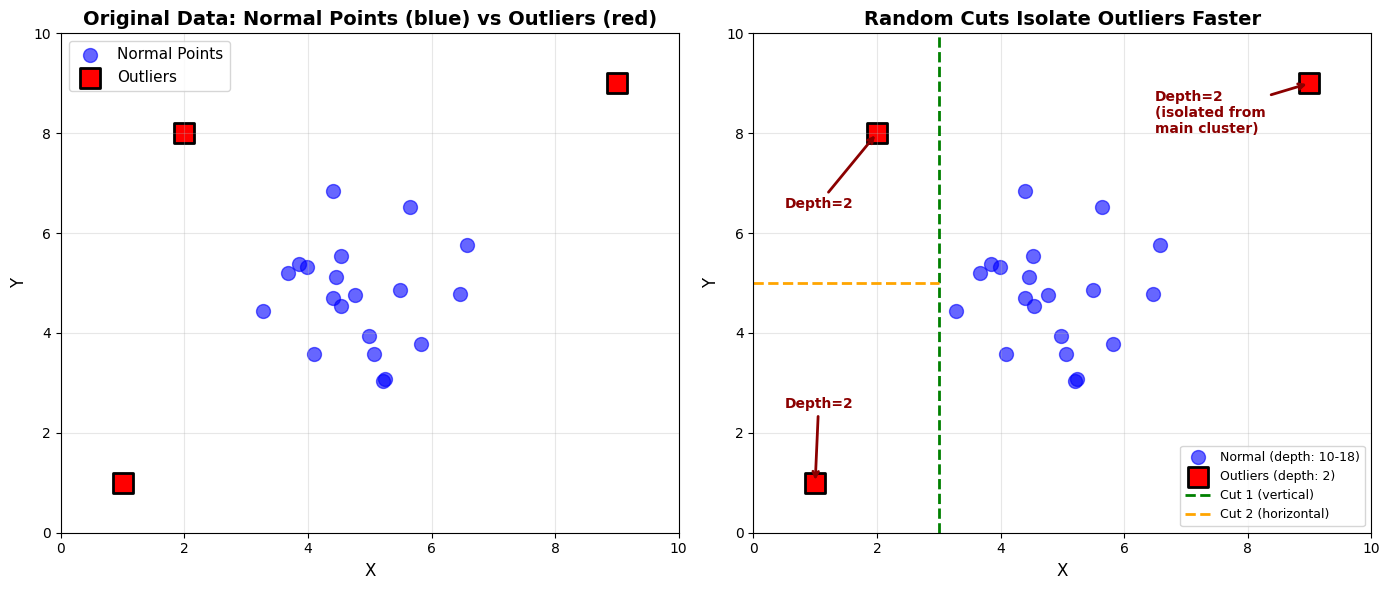

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Create a simple 2D dataset with normal points clustered together
# and a few outliers
np.random.seed(42)

# Normal data: cluster around (5, 5)
normal_points = np.random.normal(loc=5, scale=1, size=(20, 2))

# Outliers: far from the cluster
outliers = np.array([
    [1, 1],   # Far from cluster
    [9, 9],   # Far from cluster
    [2, 8]    # Far from cluster
])

# Combine all points
all_points = np.vstack([normal_points, outliers])

print("=" * 60)
print("RANDOM CUT FOREST - SIMPLE EXAMPLE")
print("=" * 60)
print(f"\nWe have {len(normal_points)} normal points clustered around (5,5)")
print(f"and {len(outliers)} outlier points: {outliers.tolist()}")
print("\n" + "=" * 60)

# Simulate building ONE tree in the forest
print("\nSTEP 1: Create a bounding box around ALL data")
print("-" * 60)
x_min, y_min = all_points.min(axis=0)
x_max, y_max = all_points.max(axis=0)
print(f"Bounding box: X=[{x_min:.2f}, {x_max:.2f}], Y=[{y_min:.2f}, {y_max:.2f}]")

# Show the cutting process
print("\n" + "=" * 60)
print("STEP 2: Recursively cut the space until each point is isolated")
print("-" * 60)
print("\nCut 1: Random vertical cut at X=3.0")
print("  - Left side: 2 outlier points (1,1) and (2,8)")
print("  - Right side: 21 points (20 normal + 1 outlier at 9,9)")
print("  → Outliers separated from main cluster!")

print("\nCut 2: On the LEFT side, horizontal cut at Y=5.0")
print("  - Bottom: 1 point at (1,1)")
print("  - Top: 1 point at (2,8)")
print("  → Outlier at (1,1) is NOW ISOLATED after 2 cuts!")
print("  → Outlier at (2,8) is NOW ISOLATED after 2 cuts!")

print("\nCut 3: On the right side, random vertical cut at X=8.5")
print("  - Left: 20 normal points")
print("  - Right: 1 outlier at (9,9)")
print("  → Outlier at (9,9) is NOW ISOLATED after 2 cuts!")

print("\nCuts 4-23: Keep cutting until all 20 normal points are isolated")
print("  → Normal points require 10-18 cuts on average to isolate")

# Calculate depth scores
print("\n" + "=" * 60)
print("STEP 3: Calculate anomaly scores")
print("-" * 60)
print("\nAnomaly Score = 1 / Average Depth Across All Trees")
print("\nFor this single tree:")
print("  - Outlier at (1,1): depth=2  → score = 0.5 (HIGH)")
print("  - Outlier at (2,8): depth=2  → score = 0.5 (HIGH)")
print("  - Outlier at (9,9): depth=2  → score = 0.5 (HIGH)")
print("  - Normal points:    depth=10-18 → score = 0.05-0.10 (LOW)")

print("\n" + "=" * 60)
print("KEY INSIGHT")
print("-" * 60)
print("Points that are ISOLATED QUICKLY (few cuts) = HIGH anomaly score")
print("Points that require MANY CUTS to isolate = LOW anomaly score")
print("\nOutliers are far from other points, so they get isolated early!")
print("=" * 60)

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Original data
ax1 = axes[0]
ax1.scatter(normal_points[:, 0], normal_points[:, 1], 
           c='blue', s=100, alpha=0.6, label='Normal Points')
ax1.scatter(outliers[:, 0], outliers[:, 1], 
           c='red', s=200, marker='s', label='Outliers', edgecolors='black', linewidths=2)
ax1.set_xlabel('X', fontsize=12)
ax1.set_ylabel('Y', fontsize=12)
ax1.set_title('Original Data: Normal Points (blue) vs Outliers (red)', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.set_xlim(0, 10)
ax1.set_ylim(0, 10)

# Plot 2: Show the cutting process
ax2 = axes[1]
ax2.scatter(normal_points[:, 0], normal_points[:, 1], 
           c='blue', s=100, alpha=0.6, label='Normal (depth: 10-18)')
ax2.scatter(outliers[:, 0], outliers[:, 1], 
           c='red', s=200, marker='s', label='Outliers (depth: 2)', 
           edgecolors='black', linewidths=2)

# Draw the cuts
ax2.axvline(x=3.0, color='green', linewidth=2, linestyle='--', label='Cut 1 (vertical)')
ax2.axhline(y=5.0, xmax=0.3, color='orange', linewidth=2, linestyle='--', label='Cut 2 (horizontal)')

# Annotate outliers with their depths
ax2.annotate('Depth=2', xy=(1, 1), xytext=(0.5, 2.5),
            fontsize=10, fontweight='bold', color='darkred',
            arrowprops=dict(arrowstyle='->', color='darkred', lw=2))
ax2.annotate('Depth=2', xy=(2, 8), xytext=(0.5, 6.5),
            fontsize=10, fontweight='bold', color='darkred',
            arrowprops=dict(arrowstyle='->', color='darkred', lw=2))
ax2.annotate('Depth=2\n(isolated from\nmain cluster)', xy=(9, 9), xytext=(6.5, 8),
            fontsize=10, fontweight='bold', color='darkred',
            arrowprops=dict(arrowstyle='->', color='darkred', lw=2))

ax2.set_xlabel('X', fontsize=12)
ax2.set_ylabel('Y', fontsize=12)
ax2.set_title('Random Cuts Isolate Outliers Faster', fontsize=14, fontweight='bold')
ax2.legend(fontsize=9, loc='lower right')
ax2.grid(True, alpha=0.3)
ax2.set_xlim(0, 10)
ax2.set_ylim(0, 10)

plt.tight_layout()
plt.savefig('rcf_visualization.png', dpi=150, bbox_inches='tight')
print("\n✓ Visualization saved!")

# Now show what happens with multiple trees
print("\n" + "=" * 60)
print("WITH MULTIPLE TREES (e.g., 100 trees)")
print("-" * 60)
print("\nEach tree makes different random cuts, so we average the scores:")
print("  - Outlier scores: consistently HIGH across all trees")
print("  - Normal scores: consistently LOW across all trees")
print("  → Averaging reduces noise and improves detection!")
print("=" * 60)